For the analysis we mostly use standard Python packages. The two exceptions are **emcee** package we use for MCMC sampling and **corner** package we use for corner plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import data_process as dp

import os
if not os.path.exists('./Plots'):
    os.mkdir('./Plots')

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
import logit_analysis as logit

In [2]:
truncation_choices = [0.9, 0.8, 0.7]
plot_legend = []
for el in truncation_choices:
    plot_legend.append("Cap " + str(el))

df = pd.read_pickle('full_experiment_data.pkl')
print(df.shape[0],"original number of subjects")
for el in truncation_choices:
    print(df[df['probability_truncation'] == el].shape[0], "subjects in %.1lf cap group" % el)
print('')

#Filtering out too many quiz fails
df = df[df['quiz_failed'] < 2]

#Discarding subjects who kept loosing buttons for too long
experiment_total = dp.Decision_Process(df, drop_first_button=False)
suboptimal_subjects = np.array([True if max([(btn[:,1]-btn[:,0]).max() for btn in subj]) > 20 else False for subj in experiment_total.subjects_button_activity])
df = df[~suboptimal_subjects]
print(df.shape[0],"subjects remain after filtering")

experiment_total = dp.Decision_Process(df, drop_first_button=False)
experiment_split = []
for el in truncation_choices:
    truncation_split = df[df['probability_truncation'] == el]
    experiment_split.append(dp.Decision_Process(truncation_split))
    print(truncation_split.shape[0], "subjects in %.1lf cap group remain after filtering" % el)

3632 original number of subjects
1214 subjects in 0.9 cap group
1203 subjects in 0.8 cap group
1215 subjects in 0.7 cap group

3390 subjects remain after filtering
1151 subjects in 0.9 cap group remain after filtering
1125 subjects in 0.8 cap group remain after filtering
1114 subjects in 0.7 cap group remain after filtering


# Overall performance analysis

In [3]:
no_fails_stay_count = 0
total_stay_count = 0
for i, decisions in enumerate(experiment_split):
    no_fails_decisions = decisions.get_decisions(discard_no_fails=False)
    no_fails_decisions = no_fails_decisions[no_fails_decisions[:,1] == 0]
    no_fails_count = no_fails_decisions.shape[0]
    no_fails_no_quit_count = np.count_nonzero(no_fails_decisions[:,2]==0)
    deviation = np.sqrt(no_fails_no_quit_count/no_fails_count*(1-no_fails_no_quit_count/no_fails_count)/no_fails_count)
    print("Truncation " + str(truncation_choices[i]) + ",",
          "probability of staying when no fails are observed is " + \
          "%.4lf" % (100*no_fails_no_quit_count/no_fails_count) + \
          " +- %.4lf" % (2*deviation))
    no_fails_stay_count += no_fails_no_quit_count
    total_stay_count += no_fails_count
    print("Stay decisions %d, total number of decisions %d" % (np.count_nonzero(no_fails_decisions[:,2]==0), no_fails_decisions.shape[0]))
print("Total stay decisions %d, total number of decisions %d, total probability %.2lf" % (no_fails_stay_count, total_stay_count, 100*no_fails_stay_count/total_stay_count))

Truncation 0.9, probability of staying when no fails are observed is 97.5290 +- 0.0028
Stay decisions 12117, total number of decisions 12424
Truncation 0.8, probability of staying when no fails are observed is 97.0098 +- 0.0035
Stay decisions 9376, total number of decisions 9665
Truncation 0.7, probability of staying when no fails are observed is 98.1031 +- 0.0030
Stay decisions 8223, total number of decisions 8382
Total stay decisions 29716, total number of decisions 30471, total probability 97.52


Here we consider a test to show the significance of people staying with a button when it had only given wins. Suppose that people decide to quit such button with probability $p$. Suppose also we encounter $n$ such decisions and we will label each decision $x_i$, we will assume it to be $1$ when a participant decides to stay and $0$ to leave. In such case by de Moivre-Laplace theorem
$$
S = \frac{\sum\limits_{i = 1}^n x_i - n p}{\sqrt{n p(1 - p)}} \sim \mathcal{N}(0,1),
$$
where $\mathcal{N}(0,1)$ denotes the normal distribution with the mean zero and standard deviation 1.

Now we assume that people decide to randomly stay or quit, the probability than is $p = 0.5$, that allows us to make a p-value statistic

In [4]:
p_stay_no_fail = 0.5
random_quit_no_fails_stat = (no_fails_stay_count - p_stay_no_fail*total_stay_count)/np.sqrt(total_stay_count*p_stay_no_fail*(1.0 - p_stay_no_fail))
print("The statistic value is %lf" % random_quit_no_fails_stat)

The statistic value is 165.909097


Since no standard package could evaluate $\mathrm{CDF}(-166)$ for normal distribution, we are going to take the following approximation
$$
\mathrm{CDF}(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{u^2}{2}} du = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}\left[\frac{1}{|x|} + O(x^{-3})\right],
$$
as $x\to-\infty$. From this formula we get
$$
\log\mathrm{CDF}(x) \approx - \frac{x^2}{2} - \log|x| - \frac{1}{2}\log(2\pi).
$$

In [5]:
print("Decimal logarithm of a p-value is %lf" % (-(0.5*random_quit_no_fails_stat**2 + np.log(random_quit_no_fails_stat) + 0.5*np.log(2*np.pi))/np.log(10)))

Decimal logarithm of a p-value is -5979.776679


In [6]:
num_buttons_experiment = []
top_button_to_all_experiment = []
for i, el in enumerate(experiment_split):
    print("Truncation " + str(truncation_choices[i]) + ":")
    num_buttons, top_button_to_all = el.analyze_largest_contribution()
    num_buttons_experiment.append(num_buttons)
    top_button_to_all_experiment.append(top_button_to_all)

Truncation 0.9:
The average number of buttons explored is 7.665508253692441
The median number of buttons explored is 5 (IQR 3.0-9.5)
The average reward received is 64.69852302345787
Out of 1151 subjects in total 762 subjects (or 66.203% +- 0.014%) got the largest contribution from the last button
The average contribution of the button with the largest contribution is 68.99 %
The median contribution of the button with the largest contribution is 0.72 (IQR 0.47-0.96)
Truncation 0.8:
The average number of buttons explored is 8.884444444444444
The median number of buttons explored is 7 (IQR 3.0-12.0)
The average reward received is 56.949333333333335
Out of 1125 subjects in total 640 subjects (or 56.889% +- 0.015%) got the largest contribution from the last button
The average contribution of the button with the largest contribution is 64.85 %
The median contribution of the button with the largest contribution is 0.65 (IQR 0.41-0.93)
Truncation 0.7:
The average number of buttons explored is 

In [7]:
fmw_button_cumulative_counts = []
fmw_button_cumulative_ratio = []
for el in experiment_split:
    worst_f_m_w = np.array(sum([[(btn[:,1]-btn[:,0]).max() for btn in subj] for subj in el.subjects_button_activity], []))
    button_fmw, fmw_counts = np.unique(worst_f_m_w[worst_f_m_w > 0], return_counts=True)
    fmw_button_cumulative_counts.append(np.cumsum(fmw_counts))
    cumulative_count = np.cumsum(fmw_counts)/fmw_counts.sum()
    fmw_button_cumulative_ratio.append(np.insert(np.c_[button_fmw,cumulative_count],0,[0,0],axis=0))

print("Fraction of buttons left before fails - wins reached 6: %lf" % \
      (np.sum([el[6] for el in fmw_button_cumulative_counts])/np.sum([el[-1] for el in fmw_button_cumulative_counts])))

Fraction of buttons left before fails - wins reached 6: 0.966037


In [8]:
leave_fmw_diff = []
leave_cumulative_counts = []
leave_cumulative_ratio = []
for el in experiment_split:
    experiment_fmw = el.decisions[el.decisions[:,1]>el.decisions[:,0]]
    leave_fmw = experiment_fmw[experiment_fmw[:,2] == 1]
    leave_fmw_diff_el = leave_fmw[:,1]-leave_fmw[:,0]
    leave_fmw_diff.append(leave_fmw_diff_el)
    leave_presses, leave_counts = np.unique(leave_fmw_diff_el, return_counts=True)
    leave_cumulative_counts.append(np.cumsum(leave_counts))
    cumulative_count = np.cumsum(leave_counts)/leave_counts.sum()
    # leave_cumulative_ratio.append(np.c_[leave_presses,cumulative_count])
    leave_cumulative_ratio.append(np.insert(np.c_[leave_presses,cumulative_count],0,[0,0],axis=0))

print("Fraction of leave decisions that happened before fails - wins reached 6: %lf" % \
      (np.sum([el[6] for el in leave_cumulative_counts])/np.sum([el[-1] for el in leave_cumulative_counts])))

Fraction of leave decisions that happened before fails - wins reached 6: 0.967285


In [9]:
experiment_aggr = []
for el in experiment_split:
    experiment_aggr.append(dp.aggregate_by_remaining_presses(el.get_decisions(wins_more_fails=False)))
experiment_aggr_total = dp.aggregate_by_remaining_presses(np.concatenate([el.get_decisions(wins_more_fails=False) for el in experiment_split]))

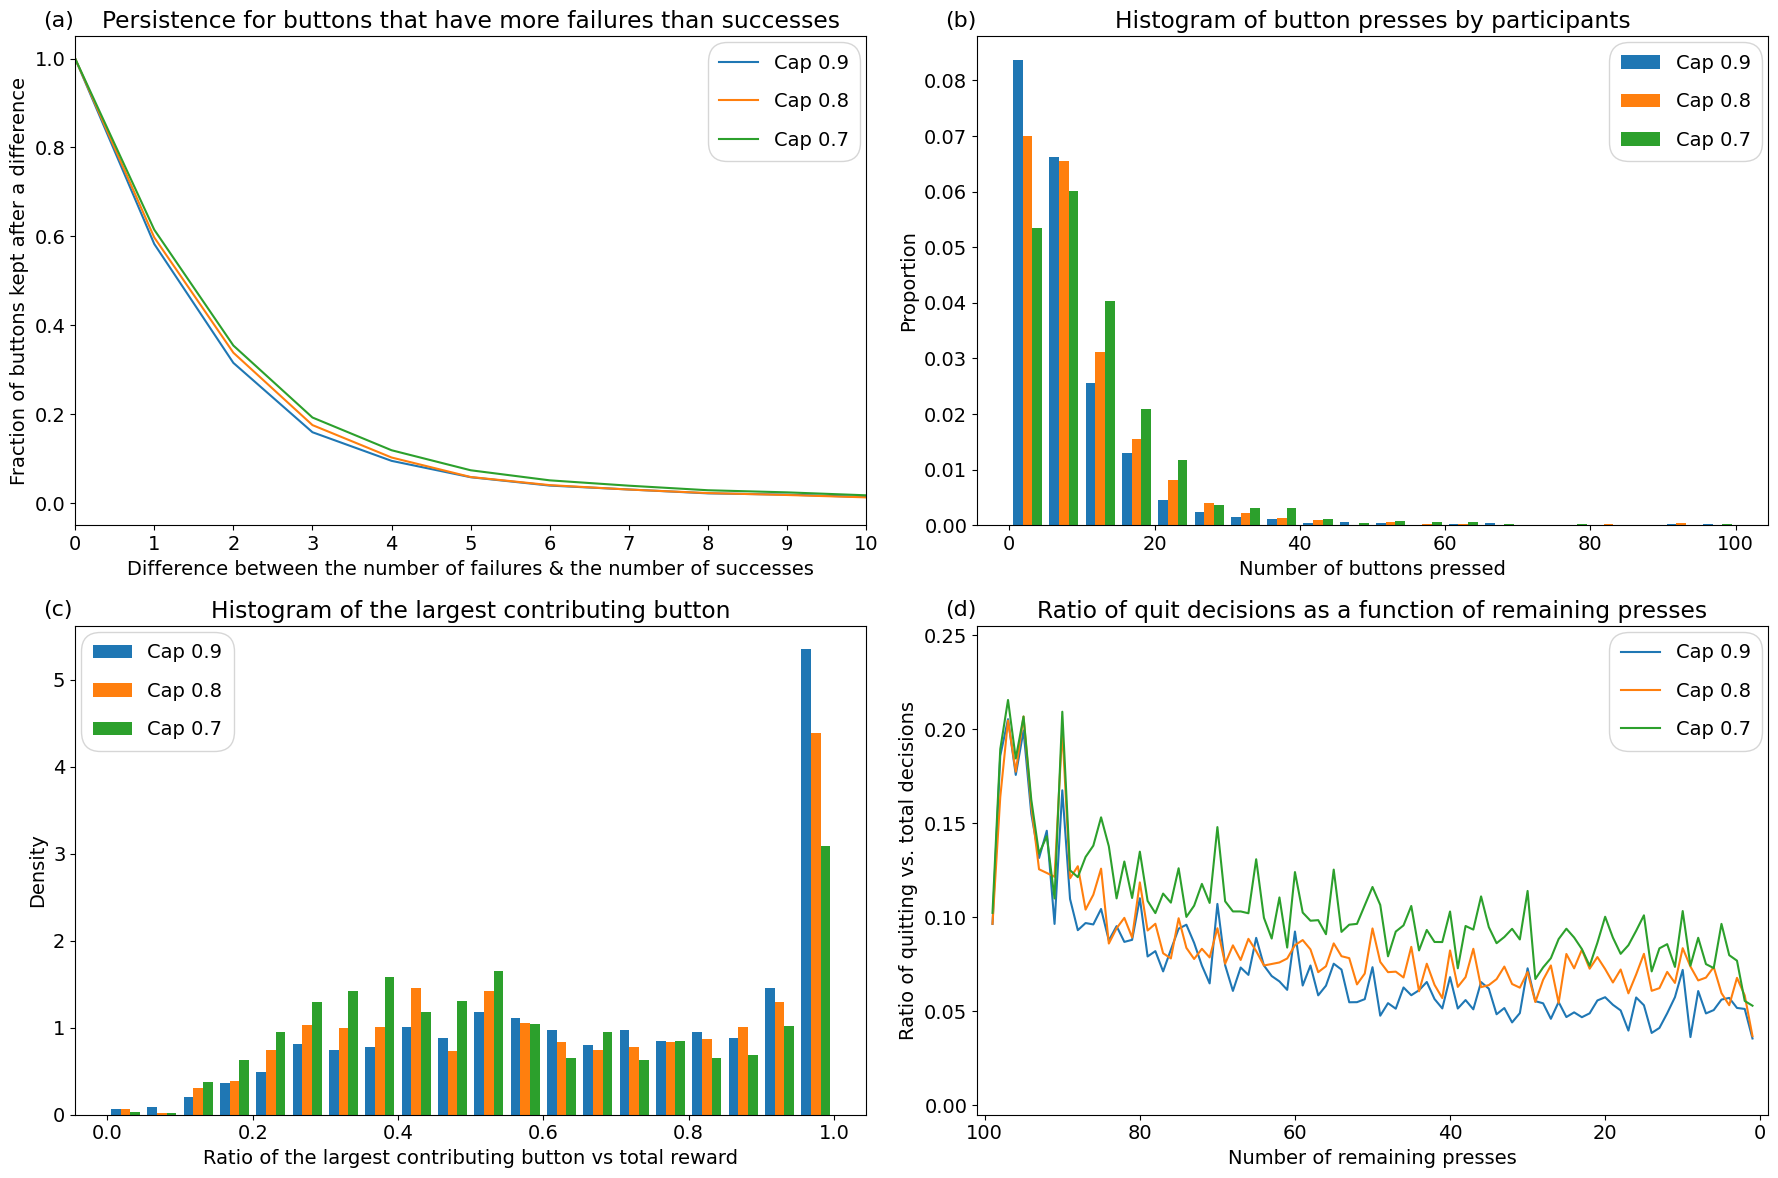

In [10]:
#Combined plot
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(18,12))

ax = fig.add_subplot(221)
ax.set_title("Persistence for buttons that have more failures than successes")
ax.annotate("(a)", xy=(-0.04, 1.02), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Difference between the number of failures & the number of successes")
ax.set_ylabel("Fraction of buttons kept after a difference")
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0, 11))
for el, label in zip(fmw_button_cumulative_ratio, plot_legend):
    plt.plot(el[:,0], 1.0-el[:,1], label=label)
ax.legend(loc='upper right',labelspacing = 1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=1)

ax = fig.add_subplot(222)
ax.set_title("Histogram of button presses by participants")
ax.annotate("(b)", xy=(-0.04, 1.02), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Number of buttons pressed")
ax.set_ylabel("Proportion")
ax.hist(num_buttons_experiment, density=True, bins=20, range=(0, 100), label=plot_legend)
ax.legend(labelspacing = 1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=1)

ax = fig.add_subplot(223)
ax.set_title("Histogram of the largest contributing button")
ax.annotate("(c)", xy=(-0.04, 1.02), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Ratio of the largest contributing button vs total reward")
ax.set_ylabel("Density")
ax.hist(top_button_to_all_experiment, density=True, bins=20, range=(0,1), label=plot_legend)
ax.legend(labelspacing = 1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=1)

ax = fig.add_subplot(224)
ax.set_title("Ratio of quit decisions as a function of remaining presses")
ax.annotate("(d)", xy=(-0.04, 1.02), xycoords='axes fraction', fontsize=16)
ax.set_xlabel("Number of remaining presses")
ax.set_xlim((-1,101))
ax.set_xticks(np.linspace(0, 100, num=6))
ax.set_ylabel("Ratio of quitting vs. total decisions")
ax.set_ylim((-0.005,0.255))
ax.set_yticks(np.linspace(0, 0.25, num=6))
for el, label in zip(experiment_aggr, plot_legend):
    ax.plot(el[:,0],el[:,1]/(el[:,1]+el[:,2]), label=label)
ax.legend(labelspacing = 1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=1)
ax.invert_xaxis()

plt.tight_layout()
plt.savefig('Plots/exp_results_new.png',dpi=120)
plt.show()

Now we perform Mann-Kendall test to test that the ratio of quit decisions as a function of remaining presses is a decreasing function
(you can use [this article](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm) for Mann-Kendall test description)

In [11]:
from scipy.stats import norm

def mann_kendall(arr):
    diffs = []
    for i in range(arr.shape[0])[:-1]:
        diffs.append(arr[i+1:] - arr[i])
    diffs = np.concatenate(diffs)
    pos_diffs = np.count_nonzero(diffs > 0)
    neg_diffs = np.count_nonzero(diffs < 0)
    
    n_el = arr.shape[0]
    _, unique_counts = np.unique(arr,return_counts=True)
    tied_counts = unique_counts[unique_counts > 1]
    var_s = (n_el*(n_el - 1)*(2*n_el+5) - sum([el*(el - 1)*(2*el+5) for el in tied_counts]))/18.0
    
    s_mk = pos_diffs - neg_diffs
    
    if s_mk > 0:
        s_mk -= 1
    elif s_mk < 0:
        s_mk += 1
    
    return s_mk/np.sqrt(var_s)

In [12]:
for el, legend_name in zip(experiment_aggr, plot_legend):
    leave_to_total = el[:,1]/(el[:,1]+el[:,2])
    mk_score = mann_kendall(leave_to_total)
    print(legend_name, "Mann-Kendall score %lf" % mk_score)
    print(legend_name, "Mann-Kendall p-value %e" % norm.cdf(-mk_score))

Cap 0.9 Mann-Kendall score 9.918953
Cap 0.9 Mann-Kendall p-value 1.721754e-23
Cap 0.8 Mann-Kendall score 9.051350
Cap 0.8 Mann-Kendall p-value 7.060570e-20
Cap 0.7 Mann-Kendall score 9.196462
Cap 0.7 Mann-Kendall p-value 1.849648e-20


# Logistic regression analysis

In [13]:
def select_decisions_win_fail(decisions, wf_pair_list):
    select_stay = []
    select_leave = []
    for el in wf_pair_list:
        wf_select = decisions[np.logical_and(decisions[:, 0] == el[0], decisions[:, 1] == el[1])]
        select_stay.append(wf_select[wf_select[:, 2] == 0][:,[0,1,3]])
        select_leave.append(wf_select[wf_select[:, 2] == 1][:,[0,1,3]])
    return (np.vstack(select_stay), np.vstack(select_leave))

In [14]:
selection_list = [[0,1], [1,1], [1,2], [1,3], [1,4], [2,1], [2,2], [2,3], [2,4], [3,1], [3,2], [3,3], [3,4], [4,1], [4,2], [4,3], [4,4], [5,1], [5,2], [5,3], [5,4]]

In [15]:
select_special_decisions = select_decisions_win_fail(experiment_total.get_decisions(), selection_list)
print("Total number of stay decisions is " + '%d' % len(select_special_decisions[0]))
print("Total number of leave decisions is " + '%d' % len(select_special_decisions[1]))

Total number of stay decisions is 71447
Total number of leave decisions is 13011


There no standard package that could evaluate $1- \mathrm{CDF}_{\chi^2_n}(x)$ for $\chi^2_n$ distribution, we are going to take the following approximation
$$
1- \mathrm{CDF}_{\chi^2_n}(x) = \frac{1}{2^\frac{n}{2}\Gamma\left(\frac{n}{2}\right)}\int\limits_{x}^\infty u^{\frac{n}{2}-1} e^{-\frac{u}{2}} du = \frac{1}{\Gamma\left(\frac{n}{2}\right)}\left(\frac{x}{2}\right)^{\frac{n}{2}-1} e^{-\frac{x}{2}}\left[1 + \frac{n-2}{x} + \frac{(n-2)(n-4)}{x^2} + O\left(x^{-3}\right)\right]
$$
as $x\to-\infty$. From this formula we get
$$
\log\left(1- \mathrm{CDF}_{\chi^2_n}(x)\right) \approx - \frac{x}{2} + \left(\frac{n}{2} - 1\right)\log\left(\frac{x}{2}\right) + \log\Gamma\left(\frac{n}{2}\right).
$$

In [16]:
print("Including presses:")
regression_special = logit.BinaryLogisticRegression(select_special_decisions[0], select_special_decisions[1])
regression_special.fit(initial_set=[-2.0, -0.3, 0.3, -0.005])
print("\nExcluding presses:")
regression_special_no_press = logit.BinaryLogisticRegression(select_special_decisions[0][:,:2], select_special_decisions[1][:,:2])
regression_special_no_press.fit()
print("\nNested model comparison:")
logit.likelihood_ratio_test(regression_special, regression_special_no_press)

Including presses:
MLE estimates:
Plane normal vector: [-0.56299999  0.49445089 -0.00609166]
Plane intercept: -1.3646538630637952
MLE value: -33397.69713208803

MAP estimates:
Plane normal vector: [-0.56299074  0.49419389 -0.0060993 ]
Plane intercept: -1.3635655078703344
MAP value: -33402.58395262549

Excluding presses:
MLE estimates:
Plane normal vector: [-0.56005003  0.49158988]
Plane intercept: -1.7232007991978957
MLE value: -33567.20191277361

MAP estimates:
Plane normal vector: [-0.55993628  0.49115425]
Plane intercept: -1.7223518292133861
MAP value: -33571.72015310975

Nested model comparison:
Chi2 value is: 339.009561
P-value of likelihood ratio test is: 0.000000
Decimal logarithm of p-value of likelihood ratio test is: -74.978157


In [17]:
print("Excluding wins:")
regression_special_no_wins = logit.BinaryLogisticRegression(select_special_decisions[0][:,[1,2]], select_special_decisions[1][:,[1,2]])
regression_special_no_wins.fit()
print("\nExcluding fails:")
regression_special_no_fails = logit.BinaryLogisticRegression(select_special_decisions[0][:,[0,2]], select_special_decisions[1][:,[0,2]])
regression_special_no_fails.fit()
print("\nNested model comparison, no wins:")
logit.likelihood_ratio_test(regression_special, regression_special_no_wins)
print("\nNested model comparison, no fails:")
logit.likelihood_ratio_test(regression_special, regression_special_no_fails)

Excluding wins:
MLE estimates:
Plane normal vector: [ 0.15727454 -0.00559634]
Plane intercept: -1.6680404858793878
MLE value: -35991.757795417594

MAP estimates:
Plane normal vector: [ 0.15699794 -0.00560601]
Plane intercept: -1.6667984170751557
MAP value: -35995.917052292454

Excluding fails:
MLE estimates:
Plane normal vector: [-0.38461432 -0.00585945]
Plane intercept: -0.7297563519594006
MLE value: -34474.634182484435

MAP estimates:
Plane normal vector: [-0.38467284 -0.0058643 ]
Plane intercept: -0.7293281908833614
MAP value: -34477.731138157294

Nested model comparison, no wins:
Chi2 value is: 5188.121327
P-value of likelihood ratio test is: 0.000000
Decimal logarithm of p-value of likelihood ratio test is: -1128.541797

Nested model comparison, no fails:
Chi2 value is: 2153.874101
P-value of likelihood ratio test is: 0.000000
Decimal logarithm of p-value of likelihood ratio test is: -469.472488


100%|█████████████████████████████████████| 10000/10000 [06:31<00:00, 25.56it/s]


Autocorrelation times: [48.18133893 47.38849445 51.87559124 47.59929111]


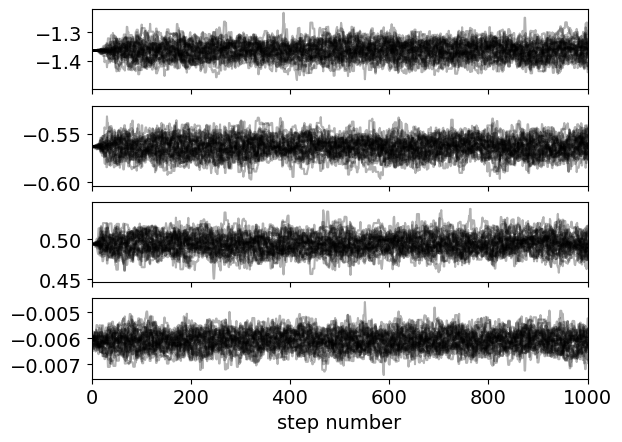

In [18]:
regression_special.run_mcmc(samples=10000)
regression_special.mcmc_diagnostic()

In [19]:
regression_special.analyze_mcmc(discard=100, thin=50, make_corner=False)

MCMC estimates:
Plane normal vector: [-0.56316683  0.49437868 -0.00609821]
Plane vector deviations: [0.00893922 0.01065637 0.00033504]
Plane intercept: -1.3638746375546402
Plane intercept deviation: 0.027414623380005373


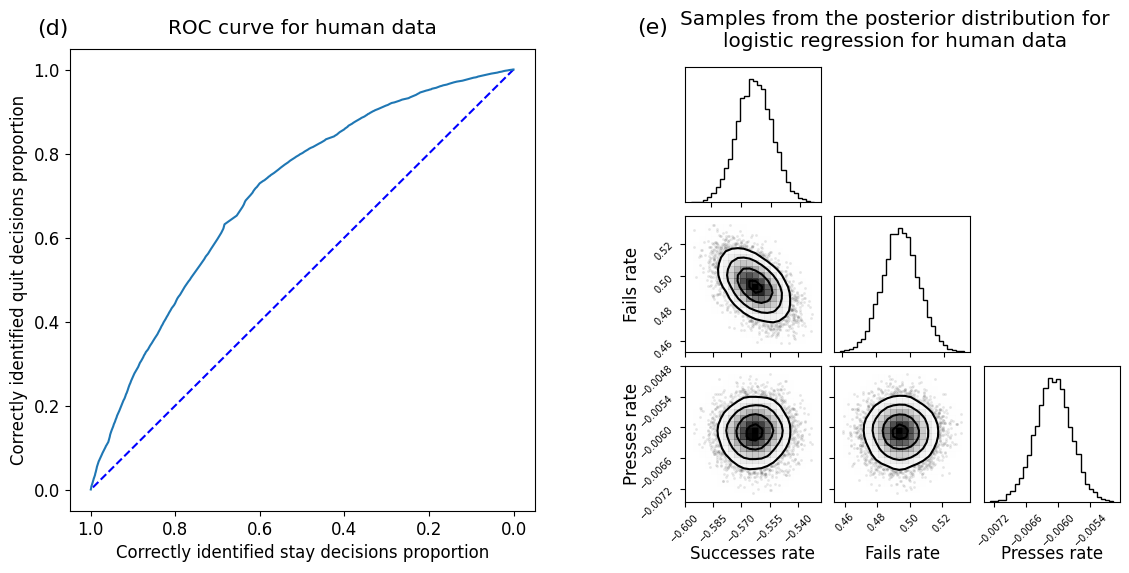

In [20]:
fig = plt.figure(figsize=(12,6))
subfigs = fig.subfigures(1, 2, wspace=0.07)
plt.rcParams.update({'font.size': 12})

ax = subfigs[0].add_subplot(111)
probability_range = np.linspace(0.0, 1.0, 11)
ax.plot(probability_range, 1.0 - probability_range, 'b--')
ax.invert_xaxis()
ax.set_title("ROC curve for human data", y=1.015)
ax.set_xlabel("Correctly identified stay decisions proportion")
ax.set_ylabel("Correctly identified quit decisions proportion")
ax.annotate("(d)", xy=(-0.07, 1.03), xycoords='axes fraction', fontsize=16)
regression_special.construct_roc_curve(select_special_decisions[0], select_special_decisions[1],
                                     npoints=1000, plot_curve=True, label="Full regression", plot=ax)

subfigs[1].suptitle('Samples from the posterior distribution for\nlogistic regression for human data', y=0.945)
mcmc_samples = regression_special.mcmc_sampler.get_chain(discard=100, thin=40, flat=True)
fig = logit.corner.corner(mcmc_samples[:,1:],
                    labels=["Successes rate", "Fails rate", "Presses rate"],
                    smooth=1,
                    # label_kwargs={'fontsize': 12},
                    hist_bin_factor=1.5,
                    # labelpad=0.02,
                    labelpad=0.02,
                    fig=subfigs[1])
subfigs[1].axes[0].annotate("(e)", xy=(-0.35, 1.24), xycoords='axes fraction', fontsize=16)
for ax in subfigs[1].axes:
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
subfigs[1].subplots_adjust(top = 0.85, bottom = 0.125, right = 0.875, left = 0.15, hspace = 0.1, wspace = 0.1)

plt.savefig("Plots/corner_roc_select.png",dpi=300)
plt.show()

## Finding regression parameters for the three cap groups separately

In [21]:
regression_special_group = []
for i, decisions in enumerate(experiment_split):
    group_decisions = select_decisions_win_fail(decisions.get_decisions(), selection_list)
    print("Truncation " + str(truncation_choices[i]))
    print("Total number of stay decisions is " + '%d' % len(group_decisions[0]))
    print("Total number of leave decisions is " + '%d' % len(group_decisions[1]))
    print('')
    regression_group = logit.BinaryLogisticRegression(group_decisions[0], group_decisions[1])
    regression_group.fit(initial_set=[-2.0, -0.3, 0.3, -0.005])
    regression_special_group.append(regression_group)
    print('')

Truncation 0.9
Total number of stay decisions is 19717
Total number of leave decisions is 3617

MLE estimates:
Plane normal vector: [-0.48828343  0.49939476 -0.00766397]
Plane intercept: -1.3016174997365795
MLE value: -9299.397953220769

MAP estimates:
Plane normal vector: [-0.48820743  0.49845827 -0.00769267]
Plane intercept: -1.2978262534175369
MAP value: -9304.162067584883

Truncation 0.8
Total number of stay decisions is 23367
Total number of leave decisions is 4194

MLE estimates:
Plane normal vector: [-0.57793401  0.5440343  -0.00768845]
Plane intercept: -1.3381310562822755
MLE value: -10707.516236490002

MAP estimates:
Plane normal vector: [-0.57781305  0.54317768 -0.00771318]
Plane intercept: -1.3348684706630092
MAP value: -10712.399824258082

Truncation 0.7
Total number of stay decisions is 28363
Total number of leave decisions is 5200

MLE estimates:
Plane normal vector: [-0.62019414  0.47264701 -0.00414523]
Plane intercept: -1.4208763336661123
MLE value: -13325.606593804489


In [22]:
for reg in regression_special_group:
    reg.run_mcmc(samples=3000)

100%|███████████████████████████████████████| 3000/3000 [00:47<00:00, 63.08it/s]


In [23]:
for i, reg in enumerate(regression_special_group):
    print("Truncation " + str(truncation_choices[i]))
    reg.analyze_mcmc(discard=100,thin=50,make_corner=False)
    print("")

Truncation 0.9
MCMC estimates:
Plane normal vector: [-0.48953197  0.49951979 -0.00773041]
Plane vector deviations: [0.01556656 0.02038652 0.00064925]
Plane intercept: -1.2959132945917997
Plane intercept deviation: 0.05412257036975593

Truncation 0.8
MCMC estimates:
Plane normal vector: [-0.57783846  0.54300978 -0.0077337 ]
Plane vector deviations: [0.01559933 0.01864843 0.00058779]
Plane intercept: -1.3329223686060105
Plane intercept deviation: 0.047756389757917746

Truncation 0.7
MCMC estimates:
Plane normal vector: [-0.62021863  0.47220008 -0.0041841 ]
Plane vector deviations: [0.01488441 0.01701509 0.00053171]
Plane intercept: -1.4184888730127618
Plane intercept deviation: 0.04263363674262239



## Running logistic regression analysis for the people who spend more time on the trial

In [24]:
practice_round_lengths = df['practice_data'].apply(len)
practice_round_duration = df['practice_data'].apply(lambda x: np.sum([el['press_time'] for el in x]))
print("Median tutorial time is:", np.median(practice_round_duration)/1000, "seconds")
print("Median number of practice round presses is:", np.median(practice_round_lengths))
#Selecting participants with more than a median number of practice presses and tutorial time
df_long_practice = df.assign(practice_time = practice_round_duration)
df_long_practice = df[np.logical_and(practice_round_duration > np.quantile(practice_round_duration, 0.5),
                                     practice_round_lengths > np.quantile(practice_round_lengths, 0.5))]
print("Number of selected participants is:", len(df_long_practice))
experiment_long_practice = dp.Decision_Process(df_long_practice, drop_first_button=False)

Median tutorial time is: 32.3235 seconds
Median number of practice round presses is: 48.0
Number of selected participants is: 1392


In [25]:
select_long_practice = select_decisions_win_fail(experiment_long_practice.get_decisions(), selection_list)
print("Total number of stay decisions is " + '%d' % len(select_long_practice[0]))
print("Total number of leave decisions is " + '%d' % len(select_long_practice[1]))

Total number of stay decisions is 28151
Total number of leave decisions is 4528


In [26]:
print("Including presses:")
regression_long_practice = logit.BinaryLogisticRegression(select_long_practice[0], select_long_practice[1])
regression_long_practice.fit()
print("\nExcluding presses:")
regression_long_practice_no_press = logit.BinaryLogisticRegression(select_long_practice[0][:,:2], select_long_practice[1][:,:2])
regression_long_practice_no_press.fit()
print("\nNested model comparison:")
logit.likelihood_ratio_test(regression_long_practice, regression_long_practice_no_press)

Including presses:
MLE estimates:
Plane normal vector: [-0.65784624  0.63184772 -0.00551267]
Plane intercept: -1.6576568400984826
MLE value: -11800.973044347884

MAP estimates:
Plane normal vector: [-0.65765386  0.63081733 -0.00554301]
Plane intercept: -1.6536438538200802
MAP value: -11806.435032320793

Excluding presses:
MLE estimates:
Plane normal vector: [-0.65452355  0.62998988]
Plane intercept: -1.9922143659595548
MLE value: -11849.13395912229

MAP estimates:
Plane normal vector: [-0.65433311  0.62886711]
Plane intercept: -1.9897031119649498
MAP value: -11854.284936365155

Nested model comparison:
Chi2 value is: 96.321830
P-value of likelihood ratio test is: 0.000000
Decimal logarithm of p-value of likelihood ratio test is: -22.005942


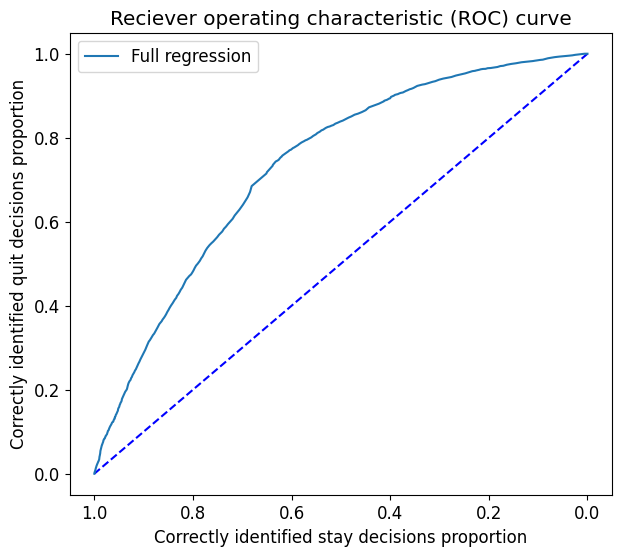

In [27]:
plt.figure(figsize=(7,6))
logit.plot_roc_frame(plt.gca())
regression_long_practice.construct_roc_curve(select_long_practice[0], select_long_practice[1],
                                     npoints=1000, plot_curve=True, label="Full regression");

plt.legend()
plt.show()

100%|███████████████████████████████████████| 3000/3000 [00:44<00:00, 67.56it/s]


Autocorrelation times: [46.50381779 44.39314482 45.21374753 48.5507737 ]


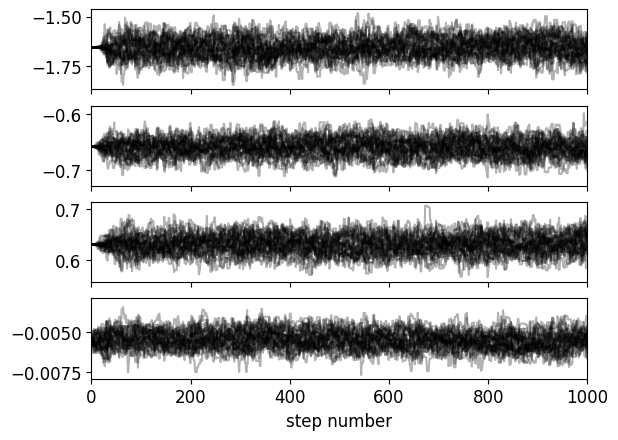

In [28]:
regression_long_practice.run_mcmc(samples=3000)
regression_long_practice.mcmc_diagnostic()

MCMC estimates:
Plane normal vector: [-0.65849337  0.63128059 -0.00553544]
Plane vector deviations: [0.01529023 0.01776636 0.00056291]
Plane intercept: -1.6541960559654767
Plane intercept deviation: 0.04856313521912065


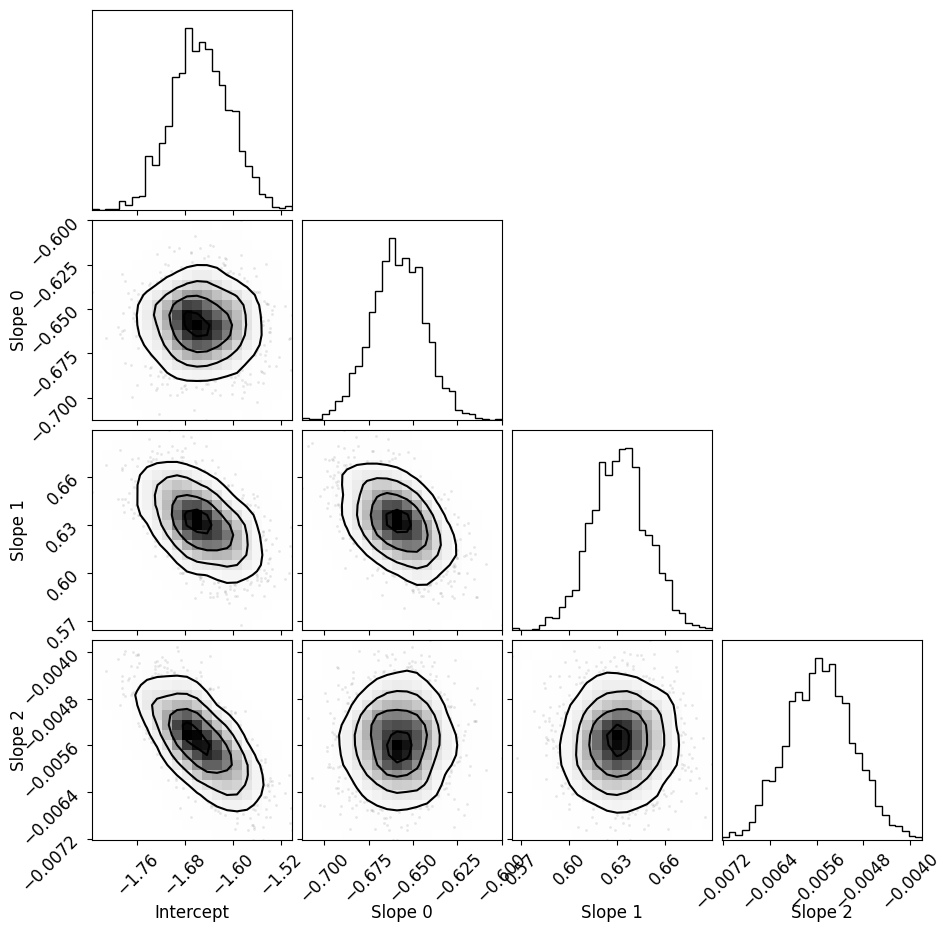

In [29]:
regression_long_practice.analyze_mcmc(discard=100, thin=50,
                    smooth=1,
                    hist_bin_factor=1.5,
                    # labelpad=0.02,
                    labelpad=0.02)